---
# Looking at residual
---

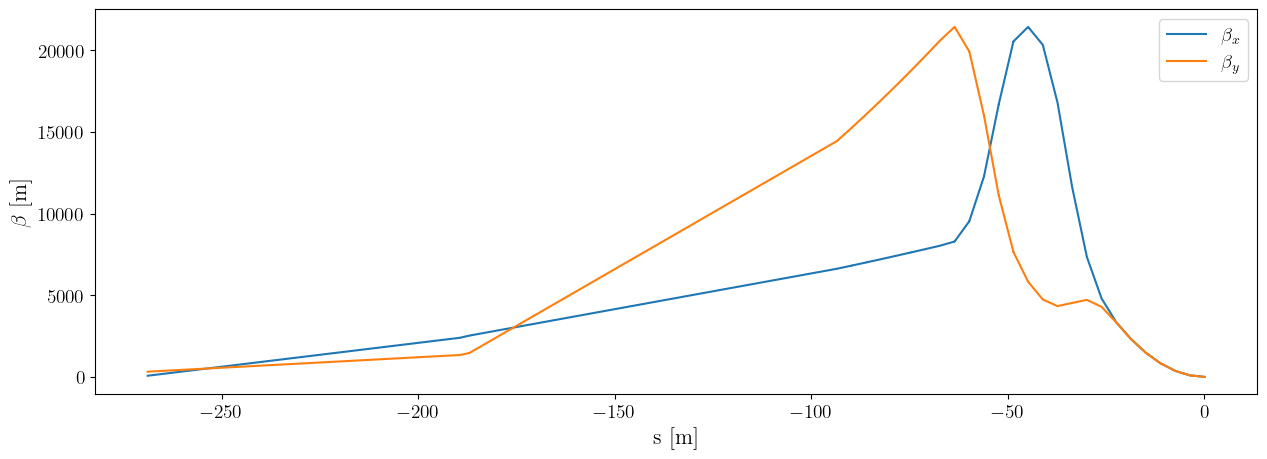

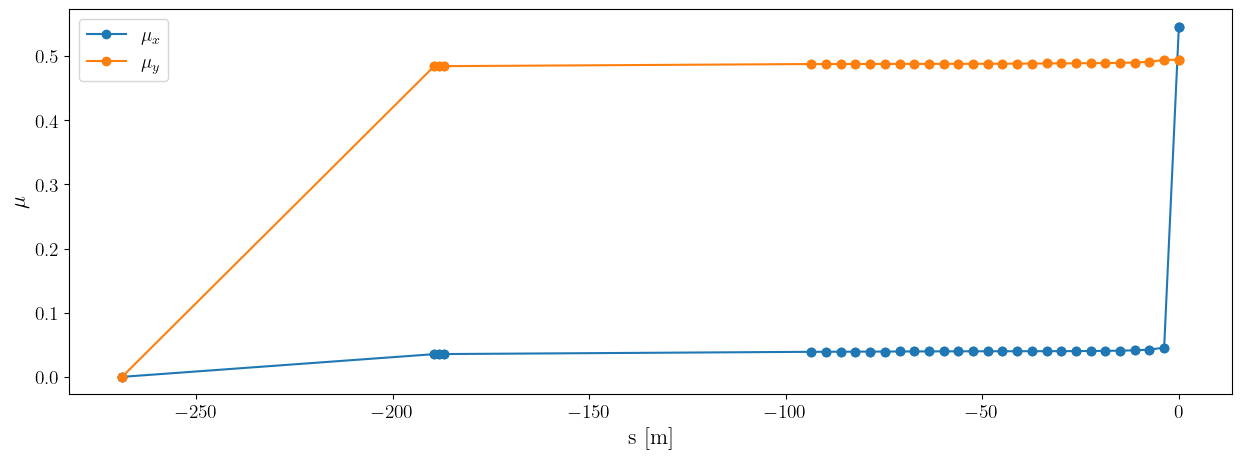

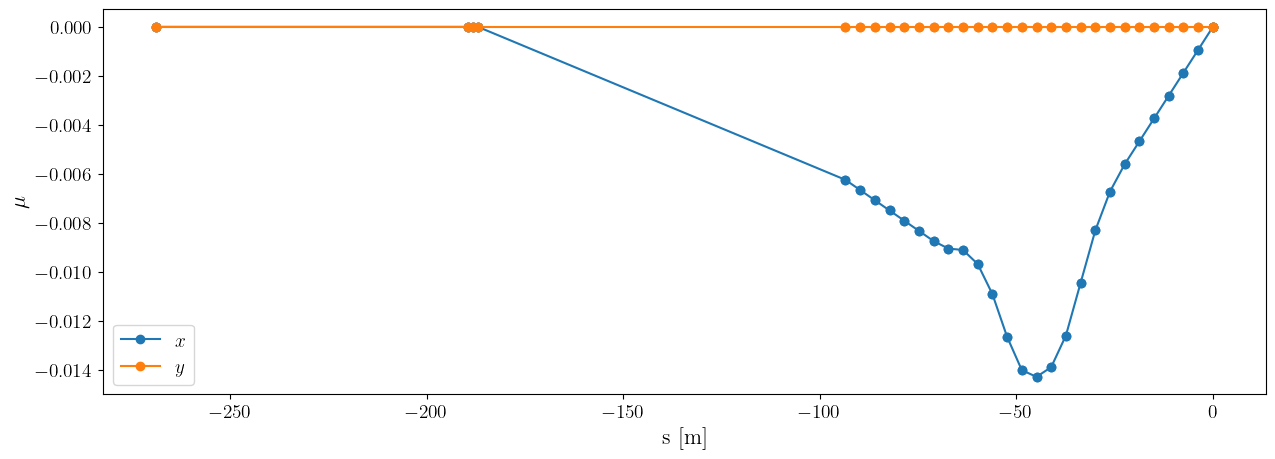

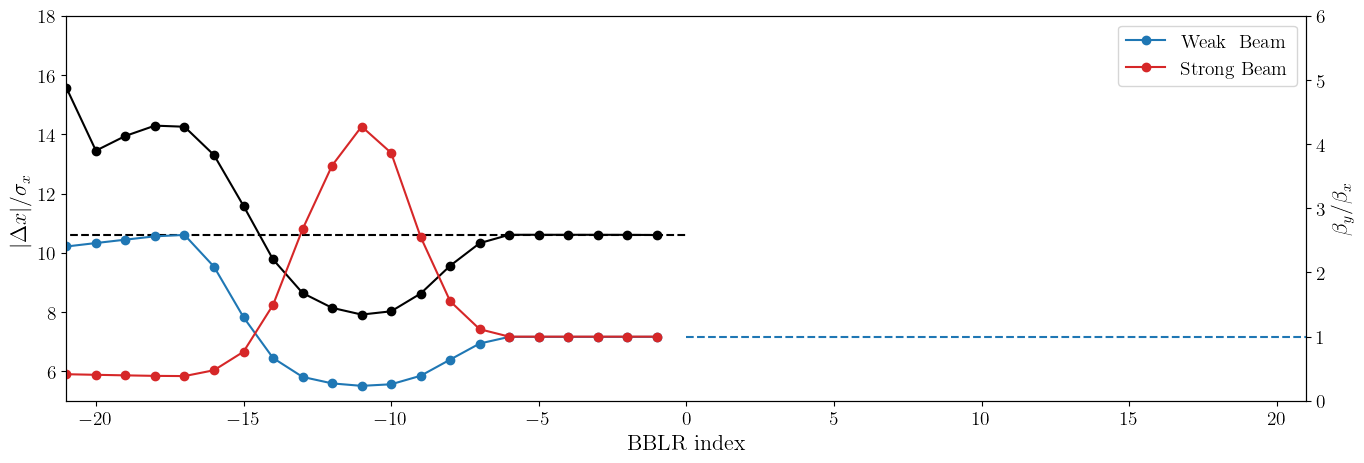

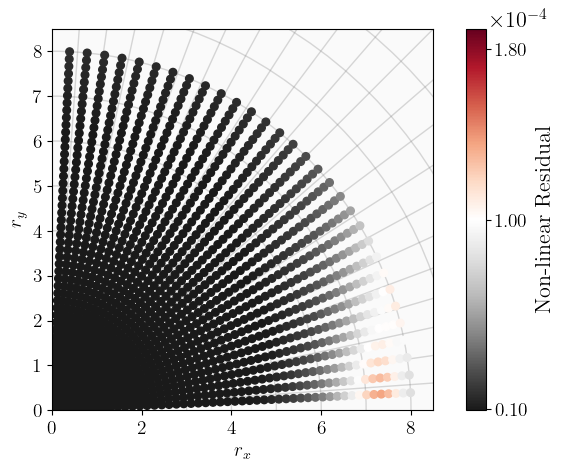

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import time 
import gc 
import os


import matplotlib.pyplot as plt
import matplotlib.colors as colors

# xsuite
import xtrack as xt
import xfields as xf
import xobjects as xo

# BBStudies
import BBStudies.Physics.Constants as cst
import BBStudies.Tracking.Buffers as xBuff
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.Utils as xutils
import BBStudies.Plotting.BBPlots as bbplt

import nafflib
from IPython.display import clear_output

# Matplotlib config
#============================
FIGPATH  = './'
FIG_W = 6
FIG_H = 6


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "xtick.labelsize":14,
    "ytick.labelsize":14,
    "axes.labelsize":16,
    "axes.titlesize":16,
    "legend.fontsize":14,
    "legend.title_fontsize":16
})
plt.rc('text.latex', preamble=r'\usepackage{physics}')
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"
#============================

def draw_slice(A,n,theta_vec,theta_other,idx):
    if not isinstance(theta_other,list):
        theta_other = [theta_other]
    assert len(theta_other) == len(n[0])-2, 'Theta should include all non-integrated angles, i.e. [Theta_y,Theta_zeta] for x-plane integration'
    
    # Computing the non-integrated phase (works for any number of dimensions)
    n_tmp      = [nk[:idx] + nk[idx+1:] for nk in n]
    varphi     = [sum([nk[i]*theta_other[i] for i in range(len(theta_other))]) for Ak,nk in zip(A,n_tmp)]


    h = sum([Ak * np.exp(1j * (nk[idx]*theta_vec + varphik))  for Ak,nk,varphik in zip(A,n,varphi)])
    return h


# Default locations
# ----------------------------
beam_list = ['b1', 'b2']
loc_list  = ['4l1','4r1','4l5','4r5']
ip_list   = ['ip1', 'ip5']
tank_list = ['a', 'b', 'c']
# ----------------------------




collider_file = 'CR_HL_data/colliders/collider_baseline_250.json'
seq           = 'lhcb1'
ip_name       = 'ip1'

chosen_I  = 50
chosen_dn = 12

# Tori
#---------------
n_part = int(1e3)
#------------------
r_min   = 1e-3
r_max   = 8.0
n_r     = 50
n_angles= 31
#--------------------
radial_list = np.linspace(r_min, r_max, n_r)
theta_list  = np.linspace(0, np.pi/2, n_angles + 2)[1:-1]
rr,tt       = np.meshgrid(radial_list, theta_list)
# --------------------
rx_vec, ry_vec = rr*np.cos(tt), rr*np.sin(tt)

# rx_vec, ry_vec = np.meshgrid(np.linspace(r_min, r_max, n_r), np.linspace(r_min, r_max, n_r))
#--------------------------------
fx  = 1/2/np.sqrt(2)
fy  = 1/2/np.sqrt(3)
fz  = -1/2/np.sqrt(5)/100
#=======================================================================


# Parameters
#-------------------------------------
disable_ho  = True

if seq == 'lhcb1':
    beam_name   = 'b1'
    s_marker    = f'e.ds.l{ip_name[-1]}.b1'
    e_marker    = f'{ip_name}'
else:
    beam_name   = 'b2'
    s_marker    = f's.ds.r{ip_name[-1]}.b2'
    e_marker    = f'{ip_name}'
#-------------------------------------


# Loading collider
#-------------------------------------
collider    = xt.Multiline.from_json(collider_file)
line0       = collider[seq]
context = xo.ContextCpu(omp_num_threads='auto')


# Adjusting beam-beam
#-------------------------------------
_direction  = 'clockwise' if seq == 'lhcb1' else 'anticlockwise'
bblr_names  = collider._bb_config['dataframes'][_direction].groupby('ip_name').get_group(ip_name).groupby('label').get_group('bb_lr').index.to_list()
bbho_names  = collider._bb_config['dataframes'][_direction].groupby('ip_name').get_group(ip_name).groupby('label').get_group('bb_ho').index.to_list()
bblr_names_all  = collider._bb_config['dataframes'][_direction].groupby('label').get_group('bb_lr').index.to_list()
bbho_names_all  = collider._bb_config['dataframes'][_direction].groupby('label').get_group('bb_ho').index.to_list()

bblr_names = [nn for nn in bblr_names if  'lr.l' in nn]
bbho_names = [nn for nn in bbho_names if  'ho.l' in nn]


if disable_ho:
    for nn in bbho_names_all:
        line0.element_refs[nn].scale_strength = 0

# Making sure all LR are enabled
for nn in bblr_names_all:
    assert line0.element_refs[nn].scale_strength._value == 1, f'LR element {nn} is not enabled'







# Adjusting wires
#-------------------------------------
# Power master knobs
collider.vars[f'bbcw_enable_ff_tune'] = 1
for loc in loc_list:
    collider.vars[f'i_wire.{loc}.{beam_name}']  = 0
    collider.vars[f'dn_wire.{loc}.{beam_name}'] = 12




#***********************************************************************
# CREATING BBLR-only line
#=======================================================================


# Ref Twiss
#===========================================
for nn in bblr_names_all:
    line0.element_refs[nn].scale_strength = 0
twiss0      = line0.twiss4d()
twiss_init  = twiss0.get_twiss_init(at_element=s_marker)
for nn in bblr_names_all:
    line0.element_refs[nn].scale_strength = 1
#===========================================


# Adjusting wires
#-------------------------------------
# Power master knobs
collider.vars[f'bbcw_enable_ff_tune'] = 1
for loc in loc_list:
    collider.vars[f'i_wire.{loc}.{beam_name}']  = chosen_I
    collider.vars[f'dn_wire.{loc}.{beam_name}'] = chosen_dn




line_cut    = line0.select(s_marker,e_marker)
bbcw_names  = [nn for nn in line_cut.element_names if 'bbcw' in nn]


new_elements = [line_cut.elements[0].copy()]
new_names    = [line_cut.element_names[0]]
new_s        = [twiss0.rows[new_names[-1]].s]
for ee,nn in zip(line_cut.elements,line_cut.element_names):

    if (nn in bblr_names) or (nn in bbcw_names) or (nn in [ip_name,e_marker]):

        dqx = 0
        dqy = 0

        if (nn in [ip_name]) or (new_names[-1] in [ip_name]):
            dqx = 0.25
            dqy = 0.25
        
        if (nn in [e_marker]) or (new_names[-1] in [e_marker]):
            dqx = 1.5
            dqy = 0

        else:
            dqx = twiss0.rows[nn].mux - twiss0.rows[new_names[-1]].mux
            dqy = twiss0.rows[nn].muy - twiss0.rows[new_names[-1]].muy
        

        # ROATION
        #------------------
        new_elements.append(xPlus.linear_connector(new_names[-1],nn,twiss0,qx=dqx,qy=dqy,length=twiss0.rows[nn].s - new_s[-1]))
        new_names.append(f'rot_{nn}')
        new_s.append(twiss0.rows[nn].s)
        
        
        # # Compensator
        # #------------------
        # if (nn in bblr_names):
        #     xma = float(ee.other_beam_shift_x + ee.ref_shift_x)
        #     yma = float(ee.other_beam_shift_y + ee.ref_shift_y)
        #     current = float(ee.other_beam_num_particles * (cst.elec*cst.c))
        #     bblr_comp = xt.Wire(L_phy  = 1,L_int  =  10*1,    current = current, 
        #                                                         xma     = xma,
        #                                                         yma     = yma)
        #     # Substracting kick
        #     #------------------
        #     _tmp_particle = line0.particle_ref.copy()
        #     bblr_comp.track(_tmp_particle)
        #     bblr_comp.post_subtract_px = _tmp_particle.px[0]
        #     bblr_comp.post_subtract_py = _tmp_particle.py[0]
        #     #------------------

        #     new_elements.append(bblr_comp)
        #     new_names.append(f'cmp_{nn}')
        #     new_s.append(twiss0.rows[nn].s)

        # Element
        #------------------
        new_elements.append(ee.copy())
        new_names.append(nn)
        new_s.append(twiss0.rows[nn].s)


line = xt.Line( elements        = new_elements,
                element_names   = new_names)
line.particle_ref = line_cut.particle_ref.copy()

# Collimation emittance
#---------------------------
nemitt_x = 2.5e-6
nemitt_y = 2.5e-6
gemittx = ( nemitt_x / line.particle_ref.beta0[0] / line.particle_ref.gamma0[0])
gemitty = ( nemitt_y / line.particle_ref.beta0[0] / line.particle_ref.gamma0[0])
#---------------------------

# Monitor
#=======================================================================
monitor_name = 'buffer_monitor'
n_torus = len(rx_vec.flatten())  
monitor = xt.ParticlesMonitor(  _context      = context,
                                num_particles = int(n_torus*n_part) ,
                                start_at_turn = 0, 
                                stop_at_turn  = 1)
line.insert_element(index=line.element_names[-1], element=monitor, name=monitor_name)
twiss = line.twiss4d(start=line.element_names[0],end=line.element_names[-1],init=twiss_init)
#=======================================================================



# Buffer
#=======================================================================
buffer  = xBuff.TORUS_Buffer(complex2tuple=False,skip_naff=True)
#---------------------------------------------------------
buffer.n_torus      = n_torus
buffer.n_points     = n_part
buffer.twiss        = twiss.get_twiss_init(at_element=monitor_name)
buffer.nemitt_x     = nemitt_x
buffer.nemitt_y     = nemitt_y
buffer.nemitt_zeta  = None # To avoid any rescaling
#---------------------------------------------------------
#=======================================================================

# GENERATING TORI
#=======================================================================
Tx= 2*np.pi*fx*np.arange(n_part)
Ty= 2*np.pi*fy*np.arange(n_part)
init_coord = {'x_n':[],'px_n':[],'y_n':[],'py_n':[],'zeta_n':[],'pzeta_n':[]}
for rx,ry in zip(rx_vec.flatten(),ry_vec.flatten()):
    Gx  = rx*np.exp(1j*Tx)
    Gy  = ry*np.exp(1j*Ty)

    init_coord[f'x_n']  += list(np.real(Gx))
    init_coord[f'px_n'] += list(-np.imag(Gx))
    init_coord[f'y_n']  += list(np.real(Gy))
    init_coord[f'py_n'] += list(-np.imag(Gy))
#=======================================================================



# TRACKING
#=======================================================================
particles = line.build_particles(   x_norm   = init_coord['x_n'],
                                    px_norm  = init_coord['px_n'],
                                    y_norm   = init_coord['y_n'],
                                    py_norm  = init_coord['py_n'],
                                    method   = '4d',
                                    nemitt_x = buffer.nemitt_x,
                                    nemitt_y = buffer.nemitt_y,
                                    nemitt_zeta     = None,
                                    W_matrix        = twiss.W_matrix[0],
                                    particle_on_co  = twiss.particle_on_co.copy())

line.track(particles, num_turns= 1,turn_by_turn_monitor=True)
clear_output()
#==================================


# Processing
#==============================
buffer.process(monitor=monitor)
df_buffer = buffer.to_pandas().groupby('turn').get_group(0).set_index('torus')

residual = []
for rx,ry,(idx,torus) in zip(rx_vec.flatten(),ry_vec.flatten(),df_buffer.iterrows()):

    # Initial CS-Action
    Jx0 = rx**2/2
    Jy0 = ry**2/2

    # Average CS-Action
    Jx_avg = torus.Jx
    Jy_avg = torus.Jy

    # Relative error
    _err = np.sqrt((Jx_avg-Jx0)**2 + (Jy_avg-Jy0)**2)/np.sqrt(Jx0**2 + Jy0**2)
    
    residual.append(_err)
residual = np.array(residual)


df = pd.DataFrame({'Iw'  :chosen_I,
                    'dw' :chosen_dn,
                    'rx' :rx_vec.flatten(),
                    'ry' :ry_vec.flatten(),
                    'r'      :rr.flatten(),
                    'angle'  :tt.flatten(),
                    'residual':residual})
#===============================


#################################
# TWISS

#===================================
# PLOTTING TWISS
plt.figure(figsize=(15,5))
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.betx,label=r'$\beta_x$')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.bety,label=r'$\beta_y$')

plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\beta$ [m]')


plt.figure(figsize=(15,5))
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.mux-twiss.mux[0],'-o',label=r'$\mu_x$')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.muy-twiss.muy[0],'-o',label=r'$\mu_y$')

plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\mu$ ')

plt.figure(figsize=(15,5))
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.x,'-o',label=r'$x$')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.y,'-o',label=r'$y$')

plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\mu$ ')






twiss_keys  = ['name', 's', 'betx', 'bety','alfx','alfy','x','y','mux','muy']
bblr_dict   = {}
for ee_name in bblr_names:
    ee = line[ee_name].to_dict()

    # Twiss info
    for key in twiss_keys:
        if key not in bblr_dict.keys():
            bblr_dict[key] = []
        
        bblr_dict[key].append(twiss.rows[ee_name][key][0])


    for key in ee.keys():
        if key not in bblr_dict.keys():
            bblr_dict[key] = []
        bblr_dict[key].append(ee[key])


bblr_df = pd.DataFrame(bblr_dict)

# Computing relevant quantities
#--------
ID_limit = 25
bblr_df = bblr_df[bblr_df.name.str.contains(f'{ip_name[-1]}{seq[-2:]}')]
bblr_df.insert(0,'ID',bblr_df.name.apply(lambda name: -int(name.split('_')[-1]) if ('l1' in name or 'l5' in name) else int(name.split('_')[-1]) ))
bblr_df = bblr_df[np.abs(bblr_df.ID)<=ID_limit]
bblr_df = bblr_df.sort_values('ID')
#--------
bblr_df.insert(2,'dx_n'     ,(bblr_df.other_beam_shift_x)/np.sqrt(gemittx*bblr_df.betx))
bblr_df.insert(3,'dy_n'     ,(bblr_df.other_beam_shift_y)/np.sqrt(gemitty*bblr_df.bety))
bblr_df.insert(4,'sigx_w'   , np.sqrt(gemittx*bblr_df.betx))
bblr_df.insert(5,'sigy_w'   , np.sqrt(gemitty*bblr_df.bety))
bblr_df.insert(6,'sigx_s'   , np.sqrt(bblr_df.other_beam_Sigma_11))
bblr_df.insert(7,'sigy_s'   , np.sqrt(bblr_df.other_beam_Sigma_33))
#--------

twiss_keys  = ['name', 's', 'betx', 'bety','alfx','alfy','x','y','mux','muy']
bbcw_dict   = {}
# bbcw_names = [nn for nn in line.element_names if 'bbcw' in nn or 'wire' in nn]
for ee_name in bbcw_names:
    ee = line[ee_name].to_dict()

    # Twiss info
    for key in twiss_keys:
        if key not in bbcw_dict.keys():
            bbcw_dict[key] = []
        
        bbcw_dict[key].append(twiss.rows[ee_name][key][0])


    for key in ee.keys():
        if key not in bbcw_dict.keys():
            bbcw_dict[key] = []
        bbcw_dict[key].append(ee[key])


bbcw_df = pd.DataFrame(bbcw_dict)

# Computing relevant quantities
bbcw_df.insert(2,'rho'   , bbcw_df.bety/bbcw_df.betx)
#--------



plt.figure(figsize=(16,5))
plt.hlines(bblr_df.set_index('ID').loc[-1].dx_n,-22,0,ls='--',color='k')
plt.plot(bblr_df.ID,np.abs(bblr_df.dx_n),'-o',color='k')

plt.ylim([5,18])
plt.xlim([-21,21])
plt.ylabel(rf'$|\Delta x|/\sigma_x$')
plt.xlabel(rf'BBLR index')
plt.gca().twinx()
plt.hlines(1,0,22,ls='--',color='C0')
plt.plot(bblr_df.ID,bblr_df.sigy_w**2/bblr_df.sigx_w**2,'-o',label='Weak \  Beam')
plt.plot(bblr_df.ID,bblr_df.sigy_s**2/bblr_df.sigx_s**2,'-o',color='C3',label='Strong Beam')
plt.legend()
plt.ylim([0,6])
plt.ylabel(rf'$\beta_y/\beta_x$')



critical_res = 1e-4
vmin = critical_res*(1-0.9)
vmax = critical_res*(1+0.9)

plt.figure()
plt.scatter(df.rx,df.ry,s=30,c=df.residual,cmap='RdGy_r',vmin=vmin,vmax=vmax)
cbar = plt.colorbar(pad=-0.1)
#---------------
cbar_exponent = int(f'{critical_res:.2e}'.split('e')[1])
cbar.ax.set_yticks([1.05*vmin, critical_res, 0.95*vmax])
cbar.ax.set_yticklabels([f'{tk/10**(cbar_exponent):5.2f}' for tk in cbar.ax.get_yticks()])
cbar.ax.text(1.3, 1.01, rf'$\times 10^{{{cbar_exponent}}}$', transform=cbar.ax.transAxes,fontsize=16)
#---------------

plt.axis('square')
plt.xlim([0,df.rx.max() + 0.5])
plt.ylim([0,df.ry.max() + 0.5])
plt.gca().set_facecolor('#fafafa')  # off-white background


plt.xlabel(r'$r_x$',fontsize=14)
plt.ylabel(r'$r_y$',fontsize=14)
cbar.set_label(r'Non-linear Residual')

bbplt.polar_grid(rho_ticks=np.arange(0,20+1,1),phi_ticks=np.linspace(0,np.pi/2,21+2)[1:-1],alpha=0.3)
_theta = np.linspace(0,np.pi/2,100)
# if critical_DA is not None:
    # plt.plot(critical_DA*np.cos(_theta),critical_DA*np.sin(_theta),'--',lw=2,color='C0',label=rf'Calibration')
# plt.plot(DA_min*np.cos(_theta),DA_min*np.sin(_theta),'-',lw=3,color='C3',label=rf'CRA min: {DA_min:.2f} $\sigma$')
# plt.plot(DA_avg*np.cos(_theta),DA_avg*np.sin(_theta),'-',lw=3,color='C1',label=rf'CRA avg: {DA_avg:.2f} $\sigma$')
# plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper right',fontsize=10)
plt.tight_layout()

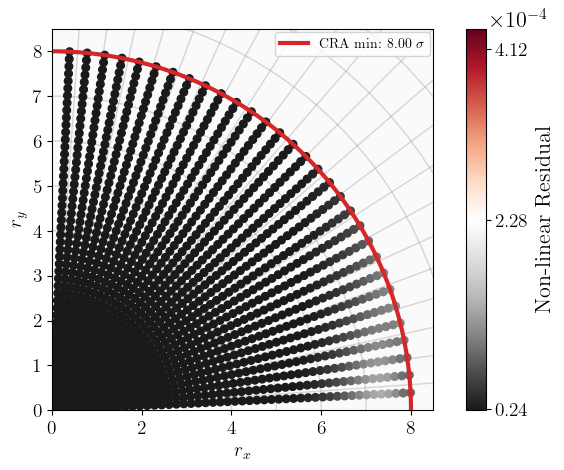

In [2]:
# # Finding critical residual
# #==========================
# critical_DA  = 5.7
# critical_roi = (np.abs(df.r - critical_DA) < 0.2)
# DA_min = []
# for _cr in df.residual[critical_roi]:
#     # Estimating DA
#     _DA_per_angle = []
#     for name,group in df.groupby(pd.cut(df.angle,1000),observed=True):
#         if np.any(group.residual>(_cr)):
#             _DA_per_angle.append(np.min(group.r[group.residual>(_cr)]))
#         else:
#             _DA_per_angle.append(np.max(group.r))
#     DA_min.append(np.min(np.array(_DA_per_angle)))
# critical_res = np.array(df.residual[critical_roi])[np.argmin(np.abs(np.array(DA_min)-critical_DA))]
# #==========================
# print(critical_res)

critical_res = 0.00022829964609752065

# Estimating DA
_DA_per_angle = []
for name,group in df.groupby(pd.cut(df.angle,1000),observed=True):
    if np.any(group.residual>(critical_res)):
        _DA_per_angle.append(np.min(group.r[group.residual>(critical_res)]))
    else:
        _DA_per_angle.append(np.max(group.r))
DA_min = np.min(np.array(_DA_per_angle))
DA_avg = np.mean(np.array(_DA_per_angle))

vmin = critical_res*(1-0.9)
vmax = critical_res*(1+0.9)

plt.figure()
plt.scatter(df.rx,df.ry,s=30,c=df.residual,cmap='RdGy_r',vmin=vmin,vmax=vmax)
cbar = plt.colorbar(pad=-0.1)
#---------------
cbar_exponent = int(f'{critical_res:.2e}'.split('e')[1])
cbar.ax.set_yticks([1.05*vmin, critical_res, 0.95*vmax])
cbar.ax.set_yticklabels([f'{tk/10**(cbar_exponent):5.2f}' for tk in cbar.ax.get_yticks()])
cbar.ax.text(1.3, 1.01, rf'$\times 10^{{{cbar_exponent}}}$', transform=cbar.ax.transAxes,fontsize=16)
#---------------

plt.axis('square')
plt.xlim([0,df.rx.max() + 0.5])
plt.ylim([0,df.ry.max() + 0.5])
plt.gca().set_facecolor('#fafafa')  # off-white background


plt.xlabel(r'$r_x$',fontsize=14)
plt.ylabel(r'$r_y$',fontsize=14)
cbar.set_label(r'Non-linear Residual')

bbplt.polar_grid(rho_ticks=np.arange(0,20+1,1),phi_ticks=np.linspace(0,np.pi/2,21+2)[1:-1],alpha=0.3)
_theta = np.linspace(0,np.pi/2,100)
# if critical_DA is not None:
    # plt.plot(critical_DA*np.cos(_theta),critical_DA*np.sin(_theta),'--',lw=2,color='C0',label=rf'Calibration')
plt.plot(DA_min*np.cos(_theta),DA_min*np.sin(_theta),'-',lw=3,color='C3',label=rf'CRA min: {DA_min:.2f} $\sigma$')
# plt.plot(DA_avg*np.cos(_theta),DA_avg*np.sin(_theta),'-',lw=3,color='C1',label=rf'CRA avg: {DA_avg:.2f} $\sigma$')
plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper right',fontsize=10)
plt.tight_layout()

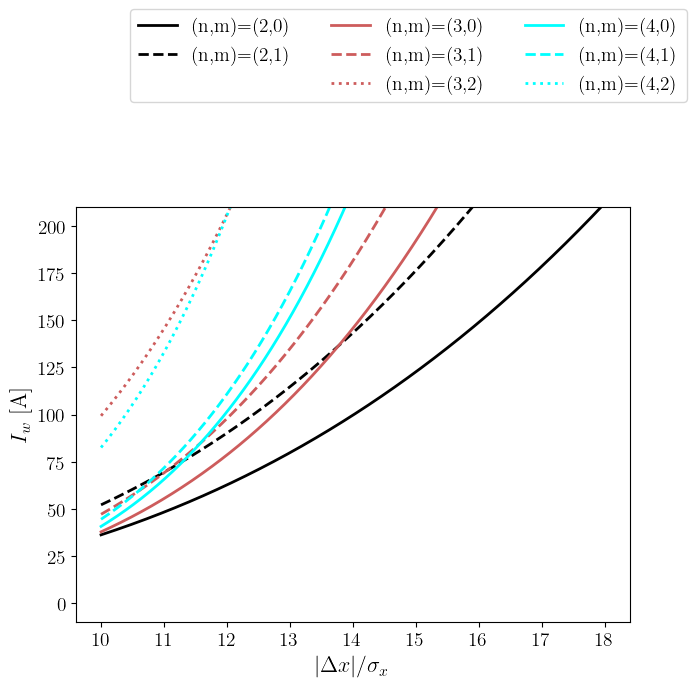

In [17]:
fig_title = f'HL_LHC_DA'
plt.figure(figsize=(6.5,5))


plt.xlabel(rf'$|\Delta x|/\sigma_x$')
plt.ylabel(r'$I_w$ [A]')
cbar.set_label(r'Dynamic Aperture [$\sigma$]')


xlims = [9.6, 18.4]
ylims = [-10.0, 210.0]
# ylims = [80.0, 520.0]
plt.xlim(xlims)
plt.ylim(ylims)

plt.tight_layout()
#====================



#===================================
# OVERLAYING CURVES

curves = [  (2,0),
            (2,1),
            (3,0),
            (3,1),
            (3,2),
            (4,0),
            (4,1),
            (4,2)]

d_curve = np.linspace(10,18,500)
color_dict = {2:'k',3:'indianred',4:'cyan'}
ls_dict = {0:'-',1:'--',2:':'}

chosen_r = 1.75

c_list = []
for _n,_m in curves:
    C = 0
    for index,bblr_info in bblr_df.iterrows():
        C += bblr_info.other_beam_num_particles*(cst.elec*cst.c) * (bblr_info.bety/bblr_info.betx)**_m / np.abs(bblr_info.dx_n)**(_n+1)
    I_curve =  C*d_curve**(_n+1)/(np.sum(bbcw_df.rho**_m))
    # I_curve =  C*d_curve**(_n+1)/(chosen_r**_m + (1/chosen_r)**_m)
    _c, = plt.plot(d_curve,I_curve,color=color_dict[_n],ls=ls_dict[_m],lw=2,alpha=1,label=f'(n,m)=({_n},{_m})')
    c_list.append(_c)

    if _n == 2 and _m == 1:
        plt.plot(np.nan,np.nan,color='k',ls='-',lw=2,alpha=0,label=f' ')

plt.legend(loc='upper center', bbox_to_anchor=(0.6, 1.5), ncol=3)
#===================================


In [13]:
bbcw_df.rho**_m + 1/bbcw_df.rho**_m,1/bbcw_df.rho**_m

(0    3.512125
 1    3.404346
 2    3.305299
 Name: rho, dtype: float64,
 0    3.199584
 1    3.079631
 2    2.968419
 Name: rho, dtype: float64)

In [5]:
bblr_df

,ID,name,dx_n,dy_n,sigx_w,sigy_w,sigx_s,sigy_s,s,betx,...,min_sigma_diff,other_beam_num_particles,ref_shift_x,other_beam_Sigma_11,other_beam_shift_y,other_beam_q0,other_beam_Sigma_33,other_beam_beta0,scale_strength,ref_shift_y
24,-25,bb_lr.l1b1_25,42.955182,0.001283,0.001489,0.002200,0.002206,0.001492,175.403428,6620.467193,...,1.000000e-10,1.132407e+11,-0.006247,4.868560e-06,2.823107e-06,1.0,2.225374e-06,1.0,1.0,-4.475231e-06
23,-24,bb_lr.l1b1_24,35.629725,0.001294,0.001511,0.002261,0.002268,0.001513,179.143451,6813.397719,...,1.000000e-10,1.132407e+11,-0.006664,5.142010e-06,2.925244e-06,1.0,2.290143e-06,1.0,1.0,-4.600030e-06
22,-23,bb_lr.l1b1_23,28.510244,0.001304,0.001533,0.002322,0.002329,0.001535,182.883473,7009.102418,...,1.000000e-10,1.132407e+11,-0.007080,5.422931e-06,3.027381e-06,1.0,2.355842e-06,1.0,1.0,-4.724828e-06
21,-22,bb_lr.l1b1_22,21.588178,0.001313,0.001554,0.002383,0.002390,0.001556,186.623496,7207.580798,...,1.000000e-10,1.132407e+11,-0.007497,5.711325e-06,3.129517e-06,1.0,2.422471e-06,1.0,1.0,-4.849627e-06
20,-21,bb_lr.l1b1_21,15.571328,0.001323,0.001576,0.002444,0.002451,0.001578,190.363519,7408.829857,...,1.000000e-10,1.132407e+11,-0.007914,6.007188e-06,3.231654e-06,1.0,2.490031e-06,1.0,1.0,-4.974426e-06
19,-20,bb_lr.l1b1_20,13.447140,0.001331,0.001597,0.002504,0.002512,0.001600,194.103542,7612.838608,...,1.000000e-10,1.132407e+11,-0.008331,6.310514e-06,3.333791e-06,1.0,2.558522e-06,1.0,1.0,-5.099225e-06
18,-19,bb_lr.l1b1_19,13.944651,0.001339,0.001619,0.002565,0.002573,0.001621,197.843565,7819.608175,...,1.000000e-10,1.132407e+11,-0.008748,6.621304e-06,3.435928e-06,1.0,2.627942e-06,1.0,1.0,-5.224023e-06
17,-18,bb_lr.l1b1_18,14.292076,0.001347,0.001640,0.002626,0.002634,0.001643,201.583588,8029.146272,...,1.000000e-10,1.132407e+11,-0.009053,6.939565e-06,3.538065e-06,1.0,2.698294e-06,1.0,1.0,-5.348822e-06
16,-17,bb_lr.l1b1_17,14.254661,0.001351,0.001666,0.002680,0.002688,0.001669,205.323611,8287.793162,...,1.000000e-10,1.132407e+11,-0.009112,7.224666e-06,3.619727e-06,1.0,2.785148e-06,1.0,1.0,-5.458294e-06
15,-16,bb_lr.l1b1_16,13.298731,0.001274,0.001787,0.002584,0.002591,0.001790,209.063634,9530.322693,...,1.000000e-10,1.132407e+11,-0.009686,6.715376e-06,3.292615e-06,1.0,3.202635e-06,1.0,1.0,-5.263075e-06


---
# Looking at topology
---

Text(0, 0.5, '$\\beta_y/\\beta_x$')

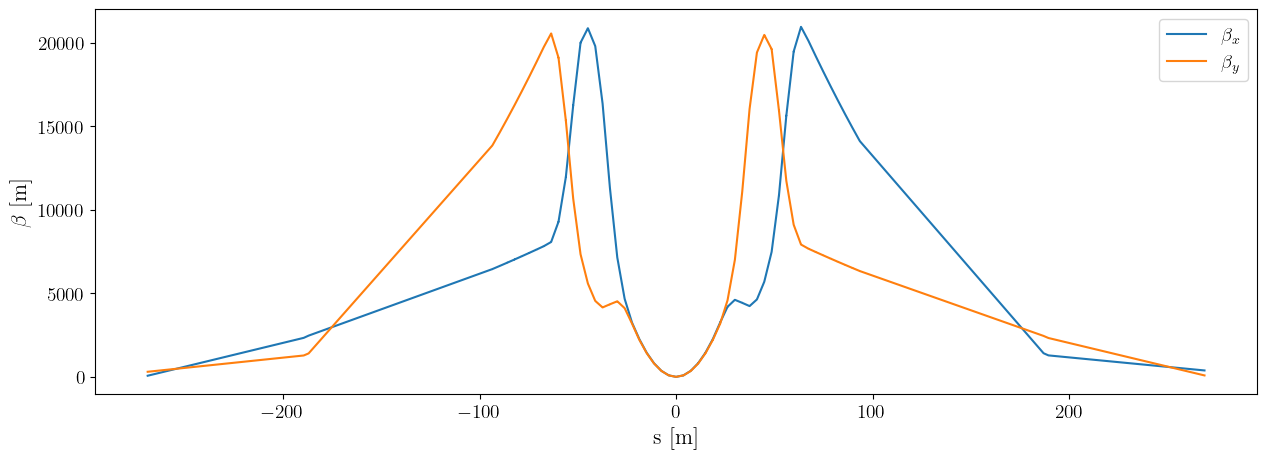

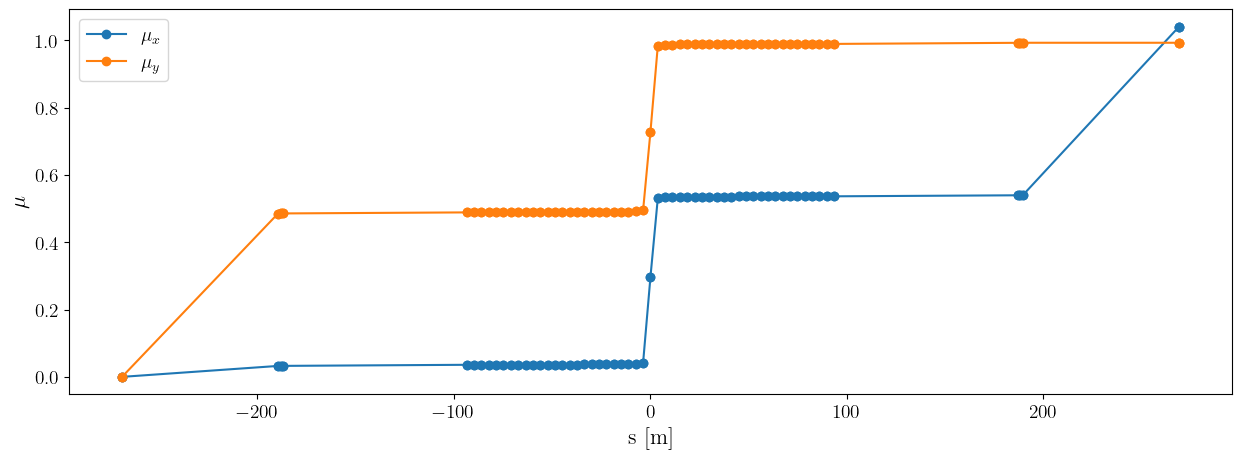

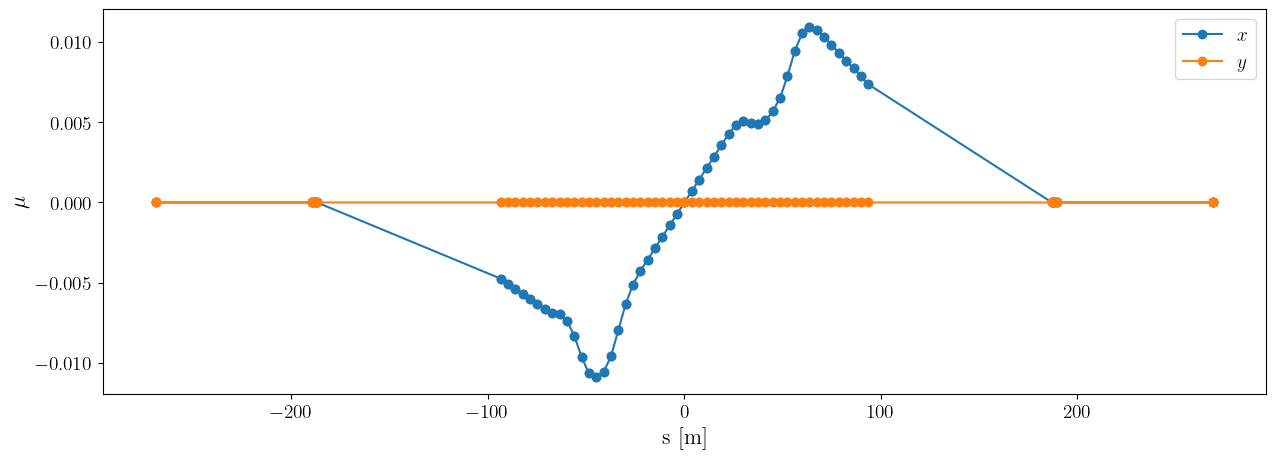

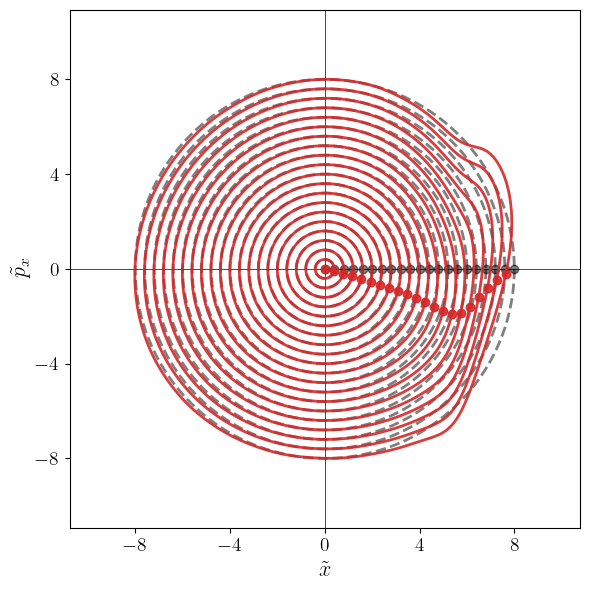

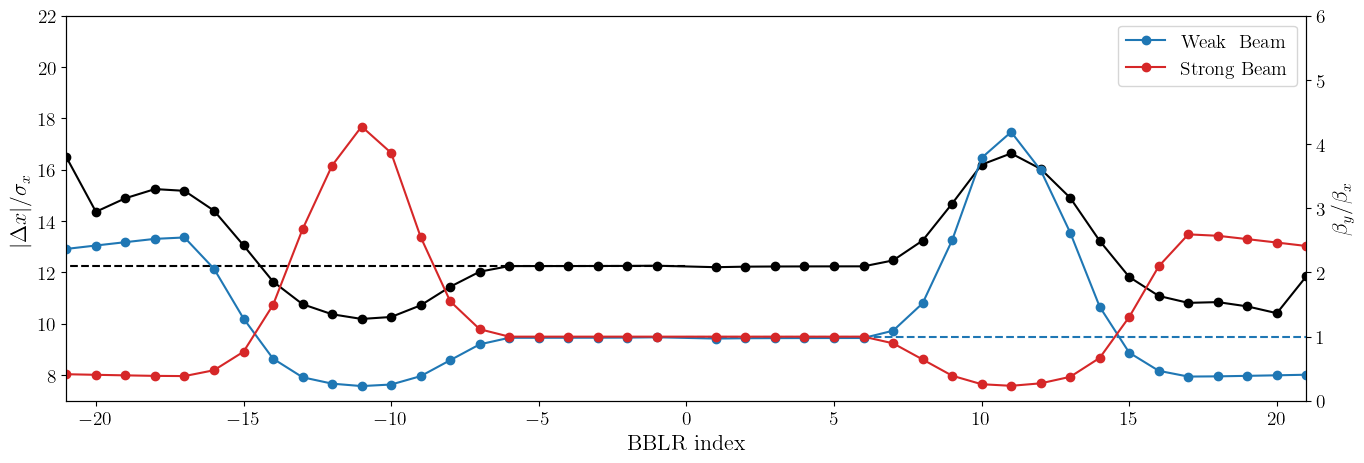

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import time 
import gc 
import os


import matplotlib.pyplot as plt
import matplotlib.colors as colors

# xsuite
import xtrack as xt
import xfields as xf
import xobjects as xo

# BBStudies
import BBStudies.Physics.Constants as cst
import BBStudies.Tracking.Buffers as xBuff
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.Utils as xutils
import BBStudies.Plotting.BBPlots as bbplt

import nafflib
from IPython.display import clear_output

# Matplotlib config
#============================
FIGPATH  = './'
FIG_W = 6
FIG_H = 6


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "xtick.labelsize":14,
    "ytick.labelsize":14,
    "axes.labelsize":16,
    "axes.titlesize":16,
    "legend.fontsize":14,
    "legend.title_fontsize":16
})
plt.rc('text.latex', preamble=r'\usepackage{physics}')
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"
#============================

def draw_slice(A,n,theta_vec,theta_other,idx):
    if not isinstance(theta_other,list):
        theta_other = [theta_other]
    assert len(theta_other) == len(n[0])-2, 'Theta should include all non-integrated angles, i.e. [Theta_y,Theta_zeta] for x-plane integration'
    
    # Computing the non-integrated phase (works for any number of dimensions)
    n_tmp      = [nk[:idx] + nk[idx+1:] for nk in n]
    varphi     = [sum([nk[i]*theta_other[i] for i in range(len(theta_other))]) for Ak,nk in zip(A,n_tmp)]


    h = sum([Ak * np.exp(1j * (nk[idx]*theta_vec + varphik))  for Ak,nk,varphik in zip(A,n,varphi)])
    return h


# Default locations
# ----------------------------
beam_list = ['b1', 'b2']
loc_list  = ['4l1','4r1','4l5','4r5']
ip_list   = ['ip1', 'ip5']
tank_list = ['a', 'b', 'c']
# ----------------------------




collider_file = 'CR_HL_data/colliders/collider_baseline_190.json'
seq           = 'lhcb1'
ip_name       = 'ip1'



# Tori
#---------------
n_part = int(1e4)
#------------------
r_min   = 1e-3
r_max   = 8
n_r     = 21
# n_angles= 5
#--------------------
radial_list = np.linspace(r_min, r_max, n_r)
theta_list  = [0]#np.linspace(0, np.pi/2, n_angles + 2)[1:-1]
rr,tt       = np.meshgrid(radial_list, theta_list)
#--------------------
rx_vec, ry_vec = rr*np.cos(tt), rr*np.sin(tt)
#--------------------------------
fx  = 1/2/np.sqrt(2)
fy  = 1/2/np.sqrt(3)
fz  = -1/2/np.sqrt(5)/100
#=======================================================================


# Parameters
#-------------------------------------
disable_ho  = True

if seq == 'lhcb1':
    beam_name   = 'b1'
    s_marker    = f'e.ds.l{ip_name[-1]}.b1'
    e_marker    = f's.ds.r{ip_name[-1]}.b1'
else:
    beam_name   = 'b2'
    s_marker    = f's.ds.r{ip_name[-1]}.b2'
    e_marker    = f'e.ds.l{ip_name[-1]}.b2'
#-------------------------------------


# Loading collider
#-------------------------------------
collider    = xt.Multiline.from_json(collider_file)
line0       = collider[seq]
context = xo.ContextCpu(omp_num_threads='auto')


# Adjusting beam-beam
#-------------------------------------
_direction  = 'clockwise' if seq == 'lhcb1' else 'anticlockwise'
bblr_names  = collider._bb_config['dataframes'][_direction].groupby('ip_name').get_group(ip_name).groupby('label').get_group('bb_lr').index.to_list()
bbho_names  = collider._bb_config['dataframes'][_direction].groupby('ip_name').get_group(ip_name).groupby('label').get_group('bb_ho').index.to_list()
bblr_names_all  = collider._bb_config['dataframes'][_direction].groupby('label').get_group('bb_lr').index.to_list()
bbho_names_all  = collider._bb_config['dataframes'][_direction].groupby('label').get_group('bb_ho').index.to_list()



if bbho_names_all:
    for nn in bbho_names:
        line0.element_refs[nn].scale_strength = 0

# Making sure all LR are enabled
for nn in bblr_names_all:
    assert line0.element_refs[nn].scale_strength._value == 1, f'LR element {nn} is not enabled'





# Adjusting wires
#-------------------------------------
# Power master knobs
collider.vars[f'bbcw_enable_ff_tune'] = 1
for loc in loc_list:
    collider.vars[f'i_wire.{loc}.{beam_name}']  = 0
    collider.vars[f'dn_wire.{loc}.{beam_name}'] = 12




#***********************************************************************
# CREATING BBLR-only line
#=======================================================================


# Ref Twiss
#===========================================
for nn in bblr_names_all:
    line0.element_refs[nn].scale_strength = 0
twiss0      = line0.twiss4d()
twiss_init  = twiss0.get_twiss_init(at_element=s_marker)
for nn in bblr_names_all:
    line0.element_refs[nn].scale_strength = 1
#===========================================


line_cut    = line0.select(s_marker,e_marker)
bbcw_names  = [nn for nn in line_cut.element_names if 'bbcw' in nn]


new_elements = [line_cut.elements[0].copy()]
new_names    = [line_cut.element_names[0]]
new_s        = [twiss0.rows[new_names[-1]].s]
for ee,nn in zip(line_cut.elements,line_cut.element_names):

    if (nn in bblr_names) or (nn in bbcw_names) or (nn in [ip_name,e_marker]):

        dqx = 0
        dqy = 0

        if (nn in [ip_name]) or (new_names[-1] in [ip_name]):
            dqx = 0.25
            dqy = 0.25
        
        if (nn in [e_marker]) or (new_names[-1] in [e_marker]):
            dqx = 1.5
            dqy = 0

        else:
            dqx = twiss0.rows[nn].mux - twiss0.rows[new_names[-1]].mux
            dqy = twiss0.rows[nn].muy - twiss0.rows[new_names[-1]].muy
        
        new_elements.append(xPlus.linear_connector(new_names[-1],nn,twiss0,qx=dqx,qy=dqy,length=twiss0.rows[nn].s - new_s[-1]))
        new_names.append(f'rot_{nn}')
        new_s.append(twiss0.rows[nn].s)
        
        new_elements.append(ee.copy())
        new_names.append(nn)
        new_s.append(twiss0.rows[nn].s)

line = xt.Line( elements        = new_elements,
                element_names   = new_names)
line.particle_ref = line_cut.particle_ref.copy()

# Collimation emittance
#---------------------------
nemitt_x = 2.5e-6
nemitt_y = 2.5e-6
gemittx = ( nemitt_x / line.particle_ref.beta0[0] / line.particle_ref.gamma0[0])
gemitty = ( nemitt_y / line.particle_ref.beta0[0] / line.particle_ref.gamma0[0])
#---------------------------

# Monitor
#=======================================================================
monitor_name = 'buffer_monitor'
n_torus = len(rx_vec.flatten())  
monitor = xt.ParticlesMonitor(  _context      = context,
                                num_particles = int(n_torus*n_part) ,
                                start_at_turn = 0, 
                                stop_at_turn  = 1)
line.insert_element(index=line.element_names[-1], element=monitor, name=monitor_name)
twiss = line.twiss4d(start=line.element_names[0],end=line.element_names[-1],init=twiss_init)
#=======================================================================





# Buffer
#=======================================================================
buffer  = xBuff.TORUS_Buffer(complex2tuple=False)
#---------------------------------------------------------
buffer.twiss      = twiss.get_twiss_init(at_element=monitor_name)
buffer.nemitt_x   = nemitt_x     
buffer.nemitt_y   = nemitt_y   
buffer.nemitt_zeta= None 
#---------------------------------------------------------
#---------------------------------------------------------
buffer.n_torus         = n_torus
buffer.n_points        = n_part
buffer.n_harm          = 50
buffer.window_order    = 4
buffer.window_type     = 'hann'
buffer.multiprocesses  = 8
#=======================================================================


# GENERATING TORI
#=======================================================================
Tx= 2*np.pi*fx*np.arange(n_part)
Ty= 2*np.pi*fy*np.arange(n_part)
init_coord = {'x_n':[],'px_n':[],'y_n':[],'py_n':[],'zeta_n':[],'pzeta_n':[]}
for rx,ry in zip(rx_vec.flatten(),ry_vec.flatten()):
    Gx  = rx*np.exp(1j*Tx)
    Gy  = ry*np.exp(1j*Ty)

    init_coord[f'x_n']  += list(np.real(Gx))
    init_coord[f'px_n'] += list(-np.imag(Gx))
    init_coord[f'y_n']  += list(np.real(Gy))
    init_coord[f'py_n'] += list(-np.imag(Gy))
#=======================================================================



# TRACKING
#=======================================================================
particles = line.build_particles(   x_norm   = init_coord['x_n'],
                                    px_norm  = init_coord['px_n'],
                                    y_norm   = init_coord['y_n'],
                                    py_norm  = init_coord['py_n'],
                                    method   = '4d',
                                    nemitt_x = buffer.nemitt_x,
                                    nemitt_y = buffer.nemitt_y,
                                    nemitt_zeta     = None,
                                    W_matrix        = twiss.W_matrix[0],
                                    particle_on_co  = twiss.particle_on_co.copy())

line.track(particles, num_turns= 1,turn_by_turn_monitor=True)
clear_output()
#==================================


# Processing
#==============================
buffer.process(monitor=monitor)
df = buffer.to_pandas().groupby('turn').get_group(0).set_index('torus')
#===============================

#################################
# TWISS

#===================================
# PLOTTING TWISS
plt.figure(figsize=(15,5))
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.betx,label=r'$\beta_x$')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.bety,label=r'$\beta_y$')

plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\beta$ [m]')


plt.figure(figsize=(15,5))
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.mux-twiss.mux[0],'-o',label=r'$\mu_x$')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.muy-twiss.muy[0],'-o',label=r'$\mu_y$')

plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\mu$ ')

plt.figure(figsize=(15,5))
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.x,'-o',label=r'$x$')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.y,'-o',label=r'$y$')

plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\mu$ ')




plt.figure(figsize=(FIG_W,FIG_H))

theta_vec = np.linspace(0,2*np.pi,1001)
p_index  = 0
# Initial
#------------------------
for rx,ry in zip(rx_vec.flatten(),ry_vec.flatten()):
    Gx  = rx*np.exp(1j*theta_vec)
    # Gy  = ry*np.exp(1j*Ty)

    plt.plot(np.real(Gx),-np.imag(Gx)       ,'--',color='k',alpha=0.5,lw=2)
    plt.plot(np.real(Gx)[p_index],-np.imag(Gx)[p_index] ,'o',color='k',alpha=0.5)
#------------------------

for _A,_Q in zip(df[f'Ax'],df[f'Qx']):
    #------------------------
    max_n = 20
    max_alias = 20
    _n = nafflib.linear_combinations(_Q,Qvec = [fx,fy],max_n=max_n,max_alias=max_alias,warning_tol=np.inf)
    #------------------------

    H = draw_slice(_A,_n,theta_vec,[0],idx = 0)

    plt.plot(np.real(H),-np.imag(H)         ,'-',color='C3',alpha=0.9,lw=2)
    plt.plot(np.real(H)[p_index],-np.imag(H)[p_index]   ,'o',color='C3',alpha=0.9)

        

plt.axhline(0,ls='-',color='k',lw=0.5,zorder = -2)
plt.axvline(0,ls='-',color='k',lw=0.5,zorder = -2)

plt.axis('equal')

plt.xticks([-8,-4,0,4,8])
plt.yticks([-8,-4,0,4,8])
plt.xlim(-11,11)
plt.ylim(-11,11)
plt.xlabel(r'$\tilde x$')
plt.ylabel(r'$\tilde p_x$')

plt.tight_layout()




twiss_keys  = ['name', 's', 'betx', 'bety','alfx','alfy','x','y','mux','muy']
bblr_dict   = {}
for ee_name in bblr_names:
    ee = line[ee_name].to_dict()

    # Twiss info
    for key in twiss_keys:
        if key not in bblr_dict.keys():
            bblr_dict[key] = []
        
        bblr_dict[key].append(twiss.rows[ee_name][key][0])


    for key in ee.keys():
        if key not in bblr_dict.keys():
            bblr_dict[key] = []
        bblr_dict[key].append(ee[key])


bblr_df = pd.DataFrame(bblr_dict)

# Computing relevant quantities
#--------
ID_limit = 25
bblr_df = bblr_df[bblr_df.name.str.contains(f'{ip_name[-1]}{seq[-2:]}')]
bblr_df.insert(0,'ID',bblr_df.name.apply(lambda name: -int(name.split('_')[-1]) if ('l1' in name or 'l5' in name) else int(name.split('_')[-1]) ))
bblr_df = bblr_df[np.abs(bblr_df.ID)<=ID_limit]
bblr_df = bblr_df.sort_values('ID')
#--------
bblr_df.insert(2,'dx_n'     ,(bblr_df.other_beam_shift_x - bblr_df.ref_shift_x)/np.sqrt(gemittx*bblr_df.betx))
bblr_df.insert(3,'dy_n'     ,(bblr_df.other_beam_shift_y - bblr_df.ref_shift_y)/np.sqrt(gemitty*bblr_df.bety))
bblr_df.insert(4,'sigx_w'   , np.sqrt(gemittx*bblr_df.betx))
bblr_df.insert(5,'sigy_w'   , np.sqrt(gemitty*bblr_df.bety))
bblr_df.insert(6,'sigx_s'   , np.sqrt(bblr_df.other_beam_Sigma_11))
bblr_df.insert(7,'sigy_s'   , np.sqrt(bblr_df.other_beam_Sigma_33))
#--------

plt.figure(figsize=(16,5))
plt.hlines(bblr_df.set_index('ID').loc[-1].dx_n,-22,0,ls='--',color='k')
plt.plot(bblr_df.ID,np.abs(bblr_df.dx_n),'-o',color='k')

plt.ylim([7,22])
plt.xlim([-21,21])
plt.ylabel(rf'$|\Delta x|/\sigma_x$')
plt.xlabel(rf'BBLR index')
plt.gca().twinx()
plt.hlines(1,0,22,ls='--',color='C0')
plt.plot(bblr_df.ID,bblr_df.sigy_w**2/bblr_df.sigx_w**2,'-o',label='Weak \  Beam')
plt.plot(bblr_df.ID,bblr_df.sigy_s**2/bblr_df.sigx_s**2,'-o',color='C3',label='Strong Beam')
plt.legend()
plt.ylim([0,6])
plt.ylabel(rf'$\beta_y/\beta_x$')